# Predict Doctor Consultation fee MachineHack(2019 Active Competition)

### Competition Link: https://www.machinehack.com/course/predict-a-doctors-consultation-fees-hackathon/

### Problem Overview: We have all been in situation where we go to a doctor in emergency and find that the consultation fees are too high. As a data scientist we all should do better. What if you have data that records important details about a doctor and you get to build a model to predict the doctor’s consulting fee.? This is the hackathon that lets you do that.

### Solution Part 2: Frequency Encoding Data, LGBM with 5-k fold validation!

In [1]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn import preprocessing, model_selection, metrics

In [26]:
train  = pd.read_feather('feather/my_train')

In [27]:
test  = pd.read_feather('feather/my_test')

In [4]:
train.shape,test.shape

((5961, 11), (1987, 10))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 11 columns):
ql1           5931 non-null object
ql2           3728 non-null object
ql3           1173 non-null object
Profile       5961 non-null object
locality      5936 non-null object
city          5935 non-null object
exp           5961 non-null float64
ratings       5961 non-null float64
no_reviews    5961 non-null float64
pop           5961 non-null float64
Fees          5961 non-null int64
dtypes: float64(4), int64(1), object(6)
memory usage: 512.4+ KB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
ql1           1980 non-null object
ql2           1287 non-null object
ql3           402 non-null object
Profile       1987 non-null object
locality      1981 non-null object
city          1981 non-null object
exp           1987 non-null float64
ratings       1987 non-null float64
no_reviews    1987 non-null float64
pop           1987 non-null float64
dtypes: float64(4), object(6)
memory usage: 155.3+ KB


In [28]:
#Changing object into categories
#Changing object into categories
train_cats(train)
apply_cats(df=test, trn=train)

In [7]:
train.info();test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 11 columns):
ql1           5931 non-null category
ql2           3728 non-null category
ql3           1173 non-null category
Profile       5961 non-null category
locality      5936 non-null category
city          5935 non-null category
exp           5961 non-null float64
ratings       5961 non-null float64
no_reviews    5961 non-null float64
pop           5961 non-null float64
Fees          5961 non-null int64
dtypes: category(6), float64(4), int64(1)
memory usage: 347.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
ql1           1967 non-null category
ql2           1273 non-null category
ql3           389 non-null category
Profile       1987 non-null category
locality      1898 non-null category
city          1981 non-null category
exp           1987 non-null float64
ratings       1987 non-null float64
no_reviews    1987 non-null 

In [8]:
#Lets filter out the categorical variables!

In [29]:
my_d = dict(train.dtypes)

In [30]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [31]:
categorical_columns = [c for c,v in my_d.items() if v not in numerics]
categorical_columns

['ql1', 'ql2', 'ql3', 'Profile', 'locality', 'city']

### Frequency_encoding locality, because of its high cardinality!

In [32]:
#Top variables with most cardinality(high number of unique values, 1000+)
frequency_encoded_variables = [
    'locality']

#Using frequency/Target  Encoding, learnt this technique from a kaggle kernel
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable)
    train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|██████████| 1/1 [00:00<00:00, 39.84it/s]


### Binary Encode the other categorical variables!

In [33]:

indexer = {}
for col in tqdm(categorical_columns):
    _, indexer[col] = pd.factorize(train[col])
    
for col in tqdm(categorical_columns):
    train[col] = indexer[col].get_indexer(train[col])+1 #Now nan will be 0!
    test[col] = indexer[col].get_indexer(test[col])+1

100%|██████████| 5/5 [00:00<00:00, 94.50it/s]


In [34]:
y = train['Fees']

In [35]:
train.drop('Fees',axis=1,inplace=True)

In [36]:
train.shape,test.shape

((5961, 10), (1987, 10))

In [18]:
train.head(3)

,ql1,ql2,ql3,Profile,locality,city,exp,ratings,no_reviews,pop
0,1,1,1,1,129.0,1,24.0,100.0,16.0,7.377759
1,2,1,1,2,5.0,2,12.0,98.0,76.0,8.915701
2,3,2,1,3,154.0,2,19.0,90.0,14.0,7.138867


In [19]:
test.head(3)

,ql1,ql2,ql3,Profile,locality,city,exp,ratings,no_reviews,pop
0,3,4,1,5,23.0,7,35.0,90.0,13.0,7.064759
1,3,7,1,3,188.0,5,31.0,90.0,13.0,7.064759
2,3,11,1,6,230.0,3,40.0,70.0,4.0,5.634790


In [37]:
categorical_columns = ['ql1', 'ql2', 'ql3','locality', 'Profile', 'city']

### Training the LGBM model!

In [38]:
params = {'num_leaves': 25,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 20,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "metric": 'rmse',
         "verbosity": -1} 

In [ ]:
#Fine tuning LGBM

In [ ]:
#Doing Stratified Cross-Fold Validation!

In [39]:
target = y.copy()

In [40]:
train.shape,target.shape

((5961, 10), (5961,))

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt

### Performing a 10 fold validation, rather than 5 because of small size of dataset!

In [42]:
#Now fine tune the model from here onwards!
folds = KFold(n_splits=10, shuffle=True, random_state=42)
categorical_columns = categorical_columns #to hold cat. columns
features = [c for c in train.columns] #features
predictions = np.zeros(len(test)) #to hold predictions
rmse_l = []
rmse_mean = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    X_train = train.iloc[trn_idx][features]
    X_valid = train.iloc[val_idx][features]
    y_train = target.iloc[trn_idx]
    y_valid = target.iloc[val_idx]

    trn_data = lgb.Dataset(X_train,
                           label=y_train,
                           categorical_feature = categorical_columns,

                          )
    val_data = lgb.Dataset(X_valid,
                           label=y_valid,
                           reference=trn_data,
                           categorical_feature = categorical_columns,

                          )

    num_round = 10000
    model = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200,
                   )
    
    
    pred_test_y = model.predict(X_valid, num_iteration=model.best_iteration)
    pred_test = model.predict(test, num_iteration=model.best_iteration)
    predictions += pred_test/5
    

    rmse = sqrt(mean_squared_error(y_valid, pred_test_y))
    rmse_l.append(rmse)
    
rmse_array = np.asarray(rmse_l)
    
rmse_mean.append(rmse_array.mean())

print('Mean rmse value: '+str(rmse_mean[0]))



fold n°0
Training until validation scores don't improve for 200 rounds.


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's rmse: 174.501	valid_1's rmse: 168.532
[1000]	training's rmse: 165.069	valid_1's rmse: 161.21
[1500]	training's rmse: 159.008	valid_1's rmse: 156.985
[2000]	training's rmse: 154.89	valid_1's rmse: 154.384
[2500]	training's rmse: 151.959	valid_1's rmse: 153.005
[3000]	training's rmse: 149.67	valid_1's rmse: 152.283
[3500]	training's rmse: 147.827	valid_1's rmse: 151.923
Early stopping, best iteration is:
[3576]	training's rmse: 147.561	valid_1's rmse: 151.911
fold n°1
Training until validation scores don't improve for 200 rounds.


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's rmse: 174.01	valid_1's rmse: 172.313
[1000]	training's rmse: 164.529	valid_1's rmse: 164.58
[1500]	training's rmse: 158.757	valid_1's rmse: 159.852
[2000]	training's rmse: 155.002	valid_1's rmse: 157.359
[2500]	training's rmse: 152.142	valid_1's rmse: 155.747
[3000]	training's rmse: 149.858	valid_1's rmse: 154.795
[3500]	training's rmse: 147.89	valid_1's rmse: 154.15
[4000]	training's rmse: 146.086	valid_1's rmse: 153.528
[4500]	training's rmse: 144.399	valid_1's rmse: 153.302
[5000]	training's rmse: 142.881	valid_1's rmse: 153.05
Early stopping, best iteration is:
[5200]	training's rmse: 142.292	valid_1's rmse: 153.029
fold n°2
Training until validation scores don't improve for 200 rounds.


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's rmse: 173.02	valid_1's rmse: 177.202
[1000]	training's rmse: 163.476	valid_1's rmse: 169.967
[1500]	training's rmse: 157.642	valid_1's rmse: 165.911
[2000]	training's rmse: 153.616	valid_1's rmse: 163.912
[2500]	training's rmse: 150.662	valid_1's rmse: 162.777
[3000]	training's rmse: 148.321	valid_1's rmse: 162.096
[3500]	training's rmse: 146.374	valid_1's rmse: 161.594
[4000]	training's rmse: 144.622	valid_1's rmse: 161.332
Early stopping, best iteration is:
[3976]	training's rmse: 144.708	valid_1's rmse: 161.327
fold n°3
Training until validation scores don't improve for 200 rounds.


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's rmse: 172.458	valid_1's rmse: 186.321
[1000]	training's rmse: 162.704	valid_1's rmse: 181.225
[1500]	training's rmse: 156.652	valid_1's rmse: 178.936
[2000]	training's rmse: 152.57	valid_1's rmse: 177.987
[2500]	training's rmse: 149.659	valid_1's rmse: 177.414
[3000]	training's rmse: 147.412	valid_1's rmse: 177.164
Early stopping, best iteration is:
[3167]	training's rmse: 146.737	valid_1's rmse: 177.058
fold n°4
Training until validation scores don't improve for 200 rounds.


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's rmse: 173.471	valid_1's rmse: 178.67
[1000]	training's rmse: 163.927	valid_1's rmse: 171.678
[1500]	training's rmse: 157.914	valid_1's rmse: 168.375
[2000]	training's rmse: 153.89	valid_1's rmse: 167.114
[2500]	training's rmse: 150.951	valid_1's rmse: 166.545
[3000]	training's rmse: 148.639	valid_1's rmse: 166.212
[3500]	training's rmse: 146.682	valid_1's rmse: 165.916
[4000]	training's rmse: 144.956	valid_1's rmse: 165.781
Early stopping, best iteration is:
[3905]	training's rmse: 145.271	valid_1's rmse: 165.733
fold n°5
Training until validation scores don't improve for 200 rounds.


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's rmse: 172.956	valid_1's rmse: 181.11
[1000]	training's rmse: 163.279	valid_1's rmse: 174.919
[1500]	training's rmse: 157.449	valid_1's rmse: 172.013
[2000]	training's rmse: 153.439	valid_1's rmse: 170.795
[2500]	training's rmse: 150.512	valid_1's rmse: 170.531
[3000]	training's rmse: 148.2	valid_1's rmse: 170.405
Early stopping, best iteration is:
[2827]	training's rmse: 148.954	valid_1's rmse: 170.361
fold n°6
Training until validation scores don't improve for 200 rounds.


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's rmse: 173.072	valid_1's rmse: 177.447
[1000]	training's rmse: 163.626	valid_1's rmse: 171.456
[1500]	training's rmse: 157.649	valid_1's rmse: 168.415
[2000]	training's rmse: 153.549	valid_1's rmse: 167.116
[2500]	training's rmse: 150.525	valid_1's rmse: 166.535
[3000]	training's rmse: 148.118	valid_1's rmse: 166.28
Early stopping, best iteration is:
[3131]	training's rmse: 147.591	valid_1's rmse: 166.246
fold n°7
Training until validation scores don't improve for 200 rounds.


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's rmse: 173.085	valid_1's rmse: 177.533
[1000]	training's rmse: 163.782	valid_1's rmse: 170.669
[1500]	training's rmse: 157.726	valid_1's rmse: 167.161
[2000]	training's rmse: 153.706	valid_1's rmse: 165.508
[2500]	training's rmse: 150.764	valid_1's rmse: 164.952
Early stopping, best iteration is:
[2796]	training's rmse: 149.328	valid_1's rmse: 164.824
fold n°8
Training until validation scores don't improve for 200 rounds.


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's rmse: 173.454	valid_1's rmse: 175.478
[1000]	training's rmse: 163.648	valid_1's rmse: 170.061
[1500]	training's rmse: 157.606	valid_1's rmse: 168.197
[2000]	training's rmse: 153.504	valid_1's rmse: 167.607
Early stopping, best iteration is:
[2027]	training's rmse: 153.325	valid_1's rmse: 167.588
fold n°9
Training until validation scores don't improve for 200 rounds.


/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/arsim/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's rmse: 174.243	valid_1's rmse: 168.572
[1000]	training's rmse: 164.948	valid_1's rmse: 161.531
[1500]	training's rmse: 158.828	valid_1's rmse: 158.52
[2000]	training's rmse: 154.829	valid_1's rmse: 156.541
[2500]	training's rmse: 151.912	valid_1's rmse: 155.558
[3000]	training's rmse: 149.623	valid_1's rmse: 155.068
Early stopping, best iteration is:
[3145]	training's rmse: 149.007	valid_1's rmse: 155.019
Mean rmse value: 163.3096425129507


In [43]:
rmse_mean

[163.3096425129507]

In [29]:
#Taking a peek at the top 10 predictions
predictions[:10]

array([268.48209, 301.0575 , 341.85774, 252.39231, 258.02174, 226.06087, 330.04826, 224.58075, 337.20188,
       267.80597])

In [134]:
len(predictions)

1987

In [44]:
pred_df_lgbm = pd.DataFrame(predictions, columns = ['Fees'])

In [45]:
pred_df_lgbm.to_excel("abhishek_lgbm_10_fold.xlsx", index = False)

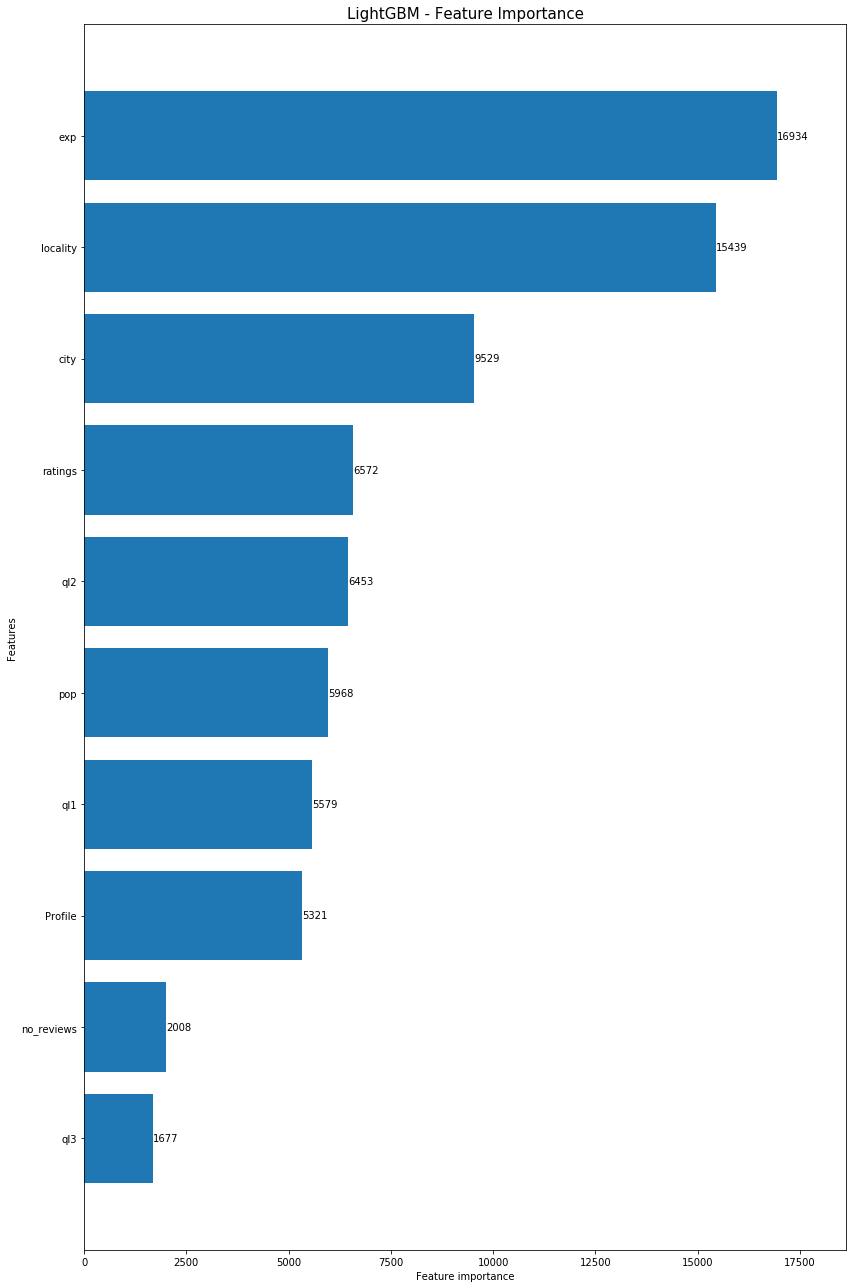

In [46]:

fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.tight_layout()
plt.savefig('lgbm_1st4mil_importances.png')
plt.show()




# Currenlty ranked in Top 40 of this competition.


### Leaderboard Link: https://www.machinehack.com/course/predict-a-doctors-consultation-fees-hackathon/leaderboard